# ===========================================================
# ML1010 - Final Project: Mid-Term Proposal
# Team NLP

## Amit Asghar
## Benjamin Kan
## Lingling Zhang
## Sophie Lee

# Sentiment Analysis for Yelp Customer Reviews on Chinese Restaurants
# ===========================================================

# Introduction

We work in a multi-national marketing firm with clients around the world servicing a wide range of industries such as chained restaurants, financial services and oil and gas firms. In order to expand our product offering, we have established a data science team to augment our existing marketing consulting services by providing clients insights and anticipating consumer trends to make their marketing campaigns become more effective. 

We have a chained Chinese restaurant client who own 50 restaurants across North America. Recently, the restaurant owner is looking into modernizing their brand to attract more Millennial customers. Our task is to create an effective marketing campaign for them. To achieve this goal, we decided to leverage our data science capabilities to conduct Sentiment Analysis on the customer reviews on Yelp for Chinese restaurants. The result of the analysis will form an important input to our marketing campaign. 
 

# Data Collection

## Data Source
The original dataset is from Yelp (https://www.yelp.com/dataset). It consists of the following sub-datasets in json format:

* business.json: Contains business data including location data, attributes, and categories.
* review.json: Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
* user.json: User data including the user's friend mapping and all the metadata associated with the user.
* checkin.json: Checkins on a business.
* tip.json: Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

In this project, we will mainly use the information in the business and review files.

The original review dataset has more than 6 million reviews. In order to select the reviews pertained to Chinese restaurants, we performed the following filtering routine:

* Using the business dataset, obtain a list of business IDs which are Chinese restaurants by searching for key word "Chinese" in the business categories column.
* Under the review dataset, select the relevant reviews based on the list of business IDs

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

In [5]:
# load business JSON file
business_df = pd.read_json("yelp_academic_dataset_business.json", lines=True)
print(business_df.head())
print(business_df.shape)

chinese_restaurants = business_df[business_df['categories'].str.contains('Chinese') == True]

print(chinese_restaurants.head())
print(chinese_restaurants.shape)

chinese_restaurants.to_csv('chinese_business.csv')

               address                                         attributes  \
0    1314 44 Avenue NE  {'BikeParking': 'False', 'BusinessAcceptsCredi...   
1                       {'Alcohol': 'none', 'BikeParking': 'False', 'B...   
2  1335 rue Beaubien E  {'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...   
3      211 W Monroe St                                               None   
4  2005 Alyth Place SE             {'BusinessAcceptsCreditCards': 'True'}   

              business_id                                         categories  \
0  Apn5Q_b6Nz61Tq4XzPdf9A  Tours, Breweries, Pizza, Restaurants, Food, Ho...   
1  AjEbIBw6ZFfln7ePHha9PA  Chicken Wings, Burgers, Caterers, Street Vendo...   
2  O8S5hYJ1SMc8fA4QBtVujA  Breakfast & Brunch, Restaurants, French, Sandw...   
3  bFzdJJ3wp3PZssNEsyU23g                      Insurance, Financial Services   
4  8USyCYqpScwiNEb58Bt6CA  Home & Garden, Nurseries & Gardening, Shopping...   

        city                                            

The code above shows that there are 4,468 Chinese restaurants. As for selecting the relevant reviews based on the business IDs for the 4,468 Chinese restaurants, because it is very computationally expensive, we extracted these reviews separately. Below is the relevant reviews in csv format.

In [6]:
# load Chinese restaurant review file
chinese_reviews_df = pd.read_csv("yelp_chinese_review.csv")
print(chinese_reviews_df.head())
print(chinese_reviews_df.shape)


   funny                 user_id               review_id  \
0      0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1      1  0pf5VuzE4_1pwj5NJHG5TQ  oyhOp2Eu7A9rsnmoV0VFgA   
2      0  0pf5VuzE4_1pwj5NJHG5TQ  8k2WpYJFfsPL3kupmvGjWA   
3      0  0pf5VuzE4_1pwj5NJHG5TQ  JvCsQXCkTkybpkJd8oSimw   
4      0  Yy_iGXxLpL6tYDQoE-6XVg  mqhCY5oLA1LXP6gZ3JQDTQ   

                                                text             business_id  \
0  Friendliest staff, no matter how swamped they ...  OX0T9dWI8b7meu-ljTo22A   
1  Been coming here for years, always delicious f...  SVMR0kRmdd-bbSNTTECJBA   
2  Best place for dim sum in the valley.  Prefer ...  szhJLmdLDVFTevm8fu0T4A   
3  Love the house chicken and chicken fried rice....  A2pHOVp0zh7grb1bbZxoBQ   
4  The spicy wonton was my favorite. We ordered a...  JPfi__QJAaRzmfh5aOyFEw   

   stars        date  useful  cool  
0      5  2016-05-01       0     0  
1      5  2016-03-06       0     0  
2      5  2016-05-01       0     0  
3      4  

As we can see, the review dataset has been narrowed down from 6 million to 227,132 reviews.

## Prepare Review Dataset for Data Exploration

In order to perform effective data exploration, we are merging the business dataset with the review dataset.

In [7]:
chinese_reviews_df_full = pd.merge(chinese_reviews_df,right=business_df, how="inner",on='business_id')
print(chinese_reviews_df_full.head())
print(chinese_reviews_df_full.shape)
chinese_reviews_df_full.to_csv('yelp_chinese_review_full.csv')

   funny                 user_id               review_id  \
0      0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1      0  ZuCXUnvBXN9wj2S8ZD40qw  0Z4uMWbCUKKtzDFeOoQt3Q   
2      0  NH7hMsA2Mogeboht1-XEVQ  AKTWTO0aUe8GMnax51aSjA   
3      0  o5hp_ni5e0SrCTczzEajuA  qrNDl6NDPS_4u8T5VJMx9g   
4      0  4SJbA5cVsHHVBt3bpGHTzg  HFFV71RDN0odsR1a7Bc9oA   

                                                text             business_id  \
0  Friendliest staff, no matter how swamped they ...  OX0T9dWI8b7meu-ljTo22A   
1  getting some food I wish it was a lot bigger t...  OX0T9dWI8b7meu-ljTo22A   
2  The place is a pit and it always has been a pi...  OX0T9dWI8b7meu-ljTo22A   
3  I have been coming to long wongs for 10 years!...  OX0T9dWI8b7meu-ljTo22A   
4  For the most part it's a unique and different ...  OX0T9dWI8b7meu-ljTo22A   

   stars_x        date  useful  cool           address  ...   \
0        5  2016-05-01       0     0  2812 E Thomas Rd  ...    
1        4  2013-12-10       0

In [8]:
print(chinese_reviews_df_full.head())

   funny                 user_id               review_id  \
0      0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1      0  ZuCXUnvBXN9wj2S8ZD40qw  0Z4uMWbCUKKtzDFeOoQt3Q   
2      0  NH7hMsA2Mogeboht1-XEVQ  AKTWTO0aUe8GMnax51aSjA   
3      0  o5hp_ni5e0SrCTczzEajuA  qrNDl6NDPS_4u8T5VJMx9g   
4      0  4SJbA5cVsHHVBt3bpGHTzg  HFFV71RDN0odsR1a7Bc9oA   

                                                text             business_id  \
0  Friendliest staff, no matter how swamped they ...  OX0T9dWI8b7meu-ljTo22A   
1  getting some food I wish it was a lot bigger t...  OX0T9dWI8b7meu-ljTo22A   
2  The place is a pit and it always has been a pi...  OX0T9dWI8b7meu-ljTo22A   
3  I have been coming to long wongs for 10 years!...  OX0T9dWI8b7meu-ljTo22A   
4  For the most part it's a unique and different ...  OX0T9dWI8b7meu-ljTo22A   

   stars_x        date  useful  cool           address  ...   \
0        5  2016-05-01       0     0  2812 E Thomas Rd  ...    
1        4  2013-12-10       0

# Data Exploration

## Overview of the Reviews

In [9]:
useful_reviews = len(chinese_reviews_df_full[chinese_reviews_df_full["useful"]>0])
cool_reviews = len(chinese_reviews_df_full[chinese_reviews_df_full["cool"]>0])
funny_reviews = len(chinese_reviews_df_full[chinese_reviews_df_full["funny"]>0])
negative_reviws = len(chinese_reviews_df_full[chinese_reviews_df_full["stars_x"]<2])
positive_reviews =len(chinese_reviews_df_full[chinese_reviews_df_full["stars_x"]>3])
total_reviews = len(chinese_reviews_df_full)

print("Total reviews: {}".format(total_reviews))
print("Useful reviews: {}".format(useful_reviews))
print("Funny reviews: {}".format(funny_reviews))
print("Cool reviews: {}".format(cool_reviews))
print("Total negative reviews: {}".format(negative_reviws))
print("Total positive reviews: {}".format(positive_reviews))

Total reviews: 227132
Useful reviews: 104596
Funny reviews: 47953
Cool reviews: 56291
Total negative reviews: 33170
Total positive reviews: 134161


## Histogram of the Review Ratings

Text(0.5, 1.0, 'Histogram for the Review Ratings')

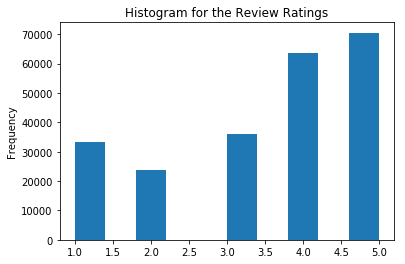

In [10]:
plt.hist(chinese_reviews_df_full['stars_x'])
plt.ylabel('Frequency');
plt.title('Histogram for the Review Ratings')

The histogram above shows that there are more positive reviews.

## Top 20 Positive Reviews Restaurants

In [14]:
top_reviewed = chinese_reviews_df_full[chinese_reviews_df_full["stars_x"]>3]
top_reviews_dict ={}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] =top_reviews_dict[business_id]+1
    except:
        top_reviews_dict[business_id]=1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")

topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
del(top_reviews_dict)
del(top_reviewed)
print(topbusiness.head())

              business_id  rated
0  OX0T9dWI8b7meu-ljTo22A     72
1  SVMR0kRmdd-bbSNTTECJBA    125
2  szhJLmdLDVFTevm8fu0T4A    269
3  A2pHOVp0zh7grb1bbZxoBQ     53
4  JPfi__QJAaRzmfh5aOyFEw    759


              business_id  rated         Business name  \
0  OX0T9dWI8b7meu-ljTo22A     72           Long Wong's   
1  SVMR0kRmdd-bbSNTTECJBA    125          Super Dragon   
2  szhJLmdLDVFTevm8fu0T4A    269    Great Wall Cuisine   
3  A2pHOVp0zh7grb1bbZxoBQ     53         Little Peking   
4  JPfi__QJAaRzmfh5aOyFEw    759  Shang Artisan Noodle   

                                          categories  
0  American (Traditional), Pizza, Restaurants, Ar...  
1                Seafood, Chinese, Restaurants, Soup  
2           Chinese, Dim Sum, Restaurants, Cantonese  
3                               Chinese, Restaurants  
4  Asian Fusion, Restaurants, Chinese, Soup, Noodles  


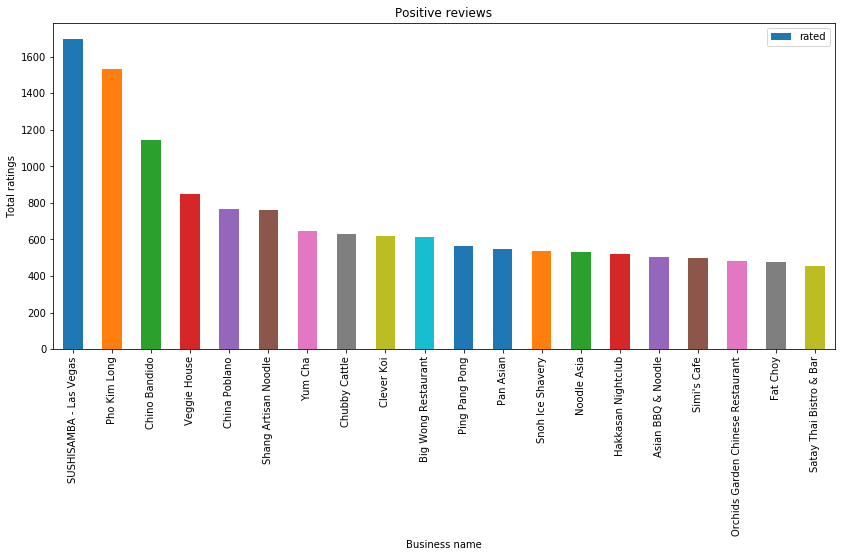

In [15]:
top_count= 20
right=pd.DataFrame(chinese_restaurants[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')

print(top_business_data.head())
top_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Positive reviews').set_ylabel("Total ratings")

del(topbusiness)
del(right)


## Top 20 Negative Positive Reviews Restaurants

In [40]:
top_reviewed = chinese_reviews_df_full[chinese_reviews_df_full["stars_x"]<3]
top_reviews_dict ={}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] =top_reviews_dict[business_id]+1
    except:
        top_reviews_dict[business_id]=1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")

topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
del(top_reviews_dict)
del(top_reviewed)
print(topbusiness.head())

              business_id  rated
0  OX0T9dWI8b7meu-ljTo22A     31
1  SVMR0kRmdd-bbSNTTECJBA     29
2  szhJLmdLDVFTevm8fu0T4A     84
3  A2pHOVp0zh7grb1bbZxoBQ      9
4  JPfi__QJAaRzmfh5aOyFEw     38


              business_id  rated         Business name  \
0  OX0T9dWI8b7meu-ljTo22A     31           Long Wong's   
1  SVMR0kRmdd-bbSNTTECJBA     29          Super Dragon   
2  szhJLmdLDVFTevm8fu0T4A     84    Great Wall Cuisine   
3  A2pHOVp0zh7grb1bbZxoBQ      9         Little Peking   
4  JPfi__QJAaRzmfh5aOyFEw     38  Shang Artisan Noodle   

                                          categories  
0  American (Traditional), Pizza, Restaurants, Ar...  
1                Seafood, Chinese, Restaurants, Soup  
2           Chinese, Dim Sum, Restaurants, Cantonese  
3                               Chinese, Restaurants  
4  Asian Fusion, Restaurants, Chinese, Soup, Noodles  


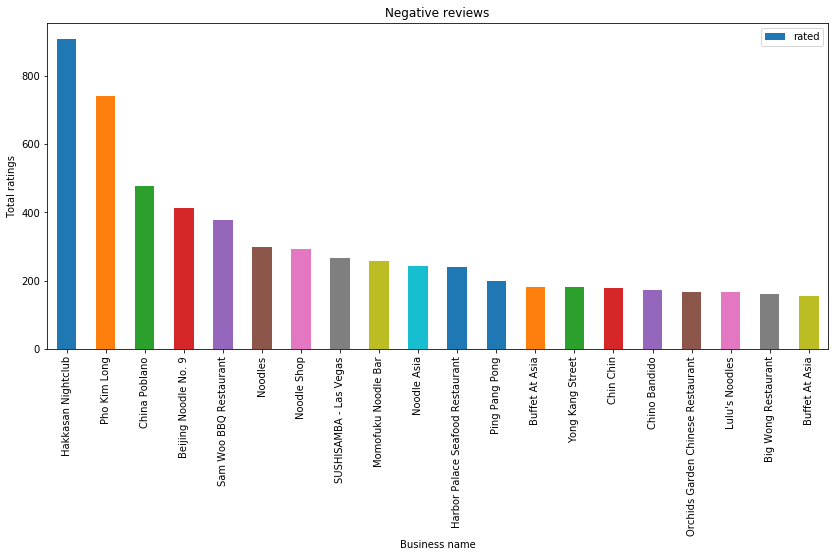

In [41]:
top_count= 20
right=pd.DataFrame(chinese[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')

print(top_business_data.head())
top_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Negative reviews').set_ylabel("Total ratings")

del(topbusiness)
del(right)